---
title: "Modeling for predicting decades"
subtitle: "DSAN 5300 Final Project"
authors: ["Jorge Bris Moreno", "William McGloin", "Kangheng Liu", "Isfar Baset"]
date: last-modified
date-format: long
format:
  html:
    self-contained: true
    toc: true
    code-overflow: wrap
    code-fold: true
---

## Introduction

In this document, we will do prediction modeling for predicting decades. We will use the balance dataset that has been adjusted by generating synthetic data using SMOTE for those underrepresented decades. We will use the following models to predict decades: Logistic regression, SVMs, and Neural Nets. Every model will have hyperparameter tuning. We will evaluate the models using accuracy, precision, recall, and F1 score.

## Data Preparation

In [2]:
# split data into training, validation and test sets
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# define the path to the data directory
tracks = pd.read_csv('../data/clean_data/balanced_tracks.csv')

# make column time_signature, decade, key, and mode to be a categorical column
tracks['time_signature'] = tracks['time_signature'].astype('category')
tracks['decade'] = tracks['decade'].astype('category')
tracks['key'] = tracks['key'].astype('category')
tracks['mode'] = tracks['mode'].astype('category')

tracks.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms,key,mode,decade
0,0.787,0.889,-3.125,0.1280,0.00951,0.000322,0.6520,0.677,156.027,4,172399,2,1,2020s
1,0.759,0.833,-5.010,0.0779,0.00026,0.057300,0.1780,0.522,140.026,4,183919,11,1,2020s
2,0.840,0.934,-3.717,0.1190,0.04840,0.000000,0.0961,0.670,149.994,4,145842,0,1,2020s
3,0.894,0.767,-4.695,0.1370,0.02310,0.000024,0.5740,0.412,144.077,4,140288,10,0,2020s
4,0.780,0.780,-2.857,0.0858,0.00147,0.000000,0.4720,0.446,118.014,4,177289,0,1,2020s


In [3]:
# split the data into training, validation and test sets with the same amount of the column "decade"
train, test = train_test_split(tracks, test_size=0.2, stratify=tracks['decade'])
train, val = train_test_split(train, test_size=0.2, stratify=train['decade'])

In [4]:
# specifying targets and features
train_target = train['decade']
train_features = train.drop(columns=['decade'])

val_target = val['decade']
val_features = val.drop(columns=['decade'])

test_target = test['decade']
test_features = test.drop(columns=['decade'])

## Logistic regression

In [4]:
# logistic regression using OVR and gridsearch for L1 and L2 regularization
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score

# Define the parameter grid
C_values = np.logspace(-4, 4, 20)
penalties = ['l1', 'l2']

best_score = 0
best_params = {'C': None, 'penalty': None}

for C in C_values:
    for penalty in penalties:
        if penalty == 'l1':
            solver = 'liblinear'  # 'liblinear' works well with L1 penalty
        else:
            solver = 'lbfgs'  # 'lbfgs' is good for L2 penalty
        
        # Initialize the Logistic Regression model
        model = LogisticRegression(C=C, penalty=penalty, solver=solver, multi_class='ovr')
        
        # Fit the model
        model.fit(train_features, train_target)
        
        # Evaluate the model on the validation set
        val_predictions = model.predict(val_features)
        score = accuracy_score(val_target, val_predictions)
        
        # Update best model if the current model is better
        if score > best_score:
            best_score = score
            best_params['C'] = C
            best_params['penalty'] = penalty
            best_model = model

# Print best parameters and best score
print("Best Parameters:", best_params)
print("Best Validation Score:", best_score)

/Users/williammcgloin/anaconda3/envs/gtown/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/williammcgloin/anaconda3/envs/gtown/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

Best Parameters: {'C': 3792.690190732246, 'penalty': 'l1'}
Best Validation Score: 0.3901014702837026


In [5]:
# Predictions on test set
test_predictions = best_model.predict(test_features)

# Evaluation
print("Accuracy on test set: ", accuracy_score(test_target, test_predictions))
print("Classification Report:\n", classification_report(test_target, test_predictions))


Accuracy on test set:  0.38630264073423676
Classification Report:
               precision    recall  f1-score   support

       1950s       0.44      0.76      0.56      3773
       1960s       0.38      0.38      0.38      3773
       1970s       0.33      0.15      0.20      3772
       1980s       0.39      0.56      0.46      3773
       1990s       0.37      0.16      0.22      3772
       2000s       0.35      0.42      0.38      3773
       2010s       0.29      0.20      0.24      3773
       2020s       0.44      0.46      0.45      3772

    accuracy                           0.39     30181
   macro avg       0.37      0.39      0.36     30181
weighted avg       0.37      0.39      0.36     30181



## SVM

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score


# Define the parameter grid
C_values = [0.1, 1, 10, 100]
gamma_values = ['scale', 'auto']
kernel_types = ['rbf']

best_score = 0
best_params = {}

for C in C_values:
    for gamma in gamma_values:
        for kernel in kernel_types:
            # Initialize the SVM model
            svm_model = SVC(C=C, gamma=gamma, kernel=kernel)

            # Fit the SVM model to the training data
            svm_model.fit(train_features, train_target)

            # Predictions on validation set
            val_predictions = svm_model.predict(val_features)

            # Calculate accuracy on the validation set
            score = accuracy_score(val_target, val_predictions)

            # Update best model if current model is better
            if score > best_score:
                best_score = score
                best_params = {'C': C, 'gamma': gamma, 'kernel': kernel}
                best_model = svm_model

# Display the best parameters and the best validation score
print("Best Parameters:", best_params)
print("Best Validation Score:", best_score)

Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best Validation Score: 0.38347483951128597


In [7]:
# Predictions on test set
test_predictions = best_model.predict(test_features)

# Evaluation
print("Accuracy on test set: ", accuracy_score(test_target, test_predictions))
print("Classification Report on Test Set:\n", classification_report(test_target, test_predictions))

Accuracy on test set:  0.3806036910639144
Classification Report on Test Set:
               precision    recall  f1-score   support

       1950s       0.86      0.36      0.51      3773
       1960s       0.85      0.37      0.52      3773
       1970s       0.77      0.30      0.43      3772
       1980s       0.83      0.30      0.44      3773
       1990s       0.81      0.30      0.43      3772
       2000s       0.78      0.29      0.42      3773
       2010s       0.17      0.90      0.29      3773
       2020s       0.64      0.23      0.33      3772

    accuracy                           0.38     30181
   macro avg       0.71      0.38      0.42     30181
weighted avg       0.71      0.38      0.42     30181



## Neural Nets

In [5]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from keras import regularizers

2024-04-12 20:25:39.189581: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
# Define a Sequential model
model = Sequential()
# Input layer with regularization; dimension should match the number of features
model.add(Dense(128, activation='relu', input_shape=(train_features.shape[1],), kernel_regularizer=regularizers.l2(0.01)))
# Dropout for regularization
model.add(Dropout(0.05))
# Additional hidden layers
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.05))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# Output layer with softmax activation for multi-class classification
model.add(Dense(8, activation='softmax'))  # 8 units for 8 categories


In [22]:
model.build()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 128)               1792      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 8)                 520       
                                                                 
Total params: 27080 (105.78 KB)
Trainable params: 2708

In [23]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
label_encoder = LabelEncoder()
train_target_encoded = label_encoder.fit_transform(train_target)


In [25]:
# learning rate annealer
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              patience=3, 
                              verbose=1, 
                              factor=0.2, 
                              min_lr=1e-6)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, verbose=1)

In [26]:
history = model.fit(train_features, train_target_encoded, epochs=50, batch_size=32, validation_split=0.2, callbacks=[reduce_lr, early_stopping])

Epoch 1/50
2415/2415 [==============================] - 5s 2ms/step - loss: 133.9296 - accuracy: 0.1258 - val_loss: 3.1083 - val_accuracy: 0.1237 - lr: 0.0010
Epoch 2/50
2415/2415 [==============================] - 5s 2ms/step - loss: 3.1283 - accuracy: 0.1229 - val_loss: 3.0189 - val_accuracy: 0.1252 - lr: 0.0010
Epoch 3/50
2415/2415 [==============================] - 4s 2ms/step - loss: 2.9776 - accuracy: 0.1253 - val_loss: 2.8883 - val_accuracy: 0.1234 - lr: 0.0010
Epoch 4/50
2415/2415 [==============================] - 4s 1ms/step - loss: 3.0621 - accuracy: 0.1233 - val_loss: 2.7787 - val_accuracy: 0.1252 - lr: 0.0010
Epoch 5/50
2406/2415 [============================>.] - ETA: 0s - loss: 2.6968 - accuracy: 0.1255
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2415/2415 [==============================] - 5s 2ms/step - loss: 2.6964 - accuracy: 0.1255 - val_loss: 2.5918 - val_accuracy: 0.1234 - lr: 0.0010
Epoch 6/50
2415/2415 [===========================

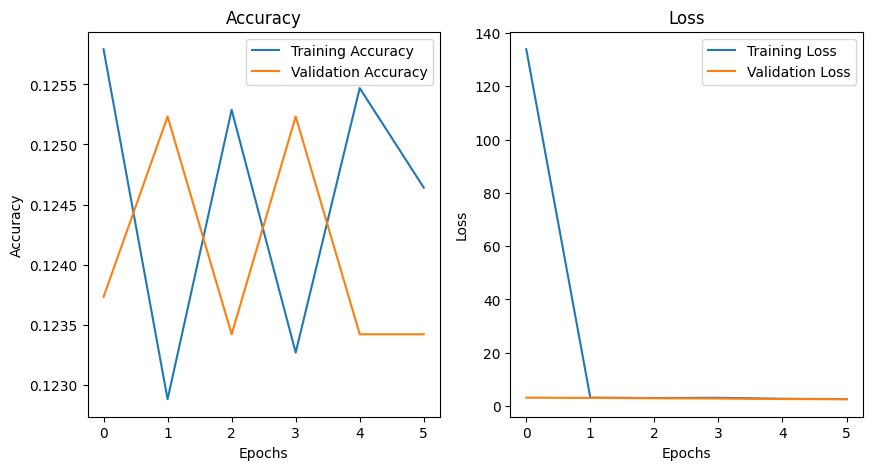

In [27]:
# Plot training and validation accuracy/loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [20]:
# You need to prepare and encode your test_target similarly to train_target if using a separate test set
test_target_encoded = label_encoder.transform(test_target)
test_loss, test_accuracy = model.evaluate(test_features, test_target_encoded)
print("Test accuracy:", test_accuracy)

944/944 [==============================] - 1s 925us/step - loss: 2.7001 - accuracy: 0.1250
Test accuracy: 0.12501242756843567


## XBGoost

In [28]:
# Assuming 'data' is your DataFrame
data = pd.read_csv('../data/clean_data/balanced_tracks.csv')  # Load your dataset instead

# Encode categorical target variable
label_encoder = LabelEncoder()
data['decade'] = label_encoder.fit_transform(data['decade'])

# Splitting data into features and target
features = data.drop('decade', axis=1)
target = data['decade']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [30]:
import xgboost as xgb

# Setting up the XGBoost classifier
model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',  # Use for multi-class classification
    num_class=len(label_encoder.classes_),  # Specify number of classes
    random_state=42
)

# Training the model
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=8,
              num_parallel_tree=None, ...)

In [31]:
from sklearn.metrics import accuracy_score, classification_report

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Accuracy: 0.49438388390046717
Classification Report:
               precision    recall  f1-score   support

       1950s       0.53      0.84      0.65      3735
       1960s       0.46      0.51      0.48      3778
       1970s       0.45      0.38      0.41      3873
       1980s       0.53      0.57      0.55      3768
       1990s       0.49      0.33      0.39      3730
       2000s       0.44      0.44      0.44      3724
       2010s       0.49      0.41      0.45      3747
       2020s       0.54      0.47      0.51      3826

    accuracy                           0.49     30181
   macro avg       0.49      0.49      0.49     30181
weighted avg       0.49      0.49      0.49     30181



In [32]:
from sklearn.model_selection import GridSearchCV

# Setting up the parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Configuring the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=2)

# Running grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50; total time=   1.6s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100; total time=   2.3s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100; total time=   2.9s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100; total time=   3.0s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200; total time=   5.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200; total time=   5.5s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200; total time=   5.4s
[CV] END learning_rate=0.01, max_depth=3, min_chil

In [33]:
# Retrieve the best model from the grid search
best_model = grid_search.best_estimator_

# Making predictions on the test set
y_test_pred = best_model.predict(X_test)

# Evaluating the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred, target_names=label_encoder.classes_)

# Print the results
print("Test Set Accuracy:", test_accuracy)
print("Test Set Classification Report:\n", test_classification_report)


Test Set Accuracy: 0.639905901063583
Test Set Classification Report:
               precision    recall  f1-score   support

       1950s       0.76      0.94      0.84      3735
       1960s       0.66      0.72      0.69      3778
       1970s       0.65      0.65      0.65      3873
       1980s       0.70      0.73      0.72      3768
       1990s       0.61      0.53      0.57      3730
       2000s       0.55      0.53      0.54      3724
       2010s       0.53      0.49      0.51      3747
       2020s       0.60      0.52      0.56      3826

    accuracy                           0.64     30181
   macro avg       0.63      0.64      0.63     30181
weighted avg       0.63      0.64      0.63     30181

